In [ ]:
# Install all the libraries we need
!pip install deepface sentence-transformers scikit-learn matplotlib tqdm kagglehub

print("All libraries installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.3 MB/s eta 0:00:00
All libraries installed!


In [ ]:
import kagglehub

path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

print("---------------------------------------------------------------")
print(f"Kaggle Path: {path}")
print("COPY THE PATH ABOVE (e.g., /root/.cache/kagglehub/...)")
print("---------------------------------------------------------------")

Using Colab cache for faster access to the 'lfw-dataset' dataset.
---------------------------------------------------------------
Kaggle Path: /kaggle/input/lfw-dataset
COPY THE PATH ABOVE (e.g., /root/.cache/kagglehub/...)
---------------------------------------------------------------


In [ ]:
# Let's list what's ACTUALLY inside your Kaggle path
!ls -l /kaggle/input/lfw-dataset/

# Let's try to find the 'Abel_Pacheco' folder.
print("\nSearching for Abel_Pacheco...")
!find /kaggle/input/lfw-dataset -type d -name "Abel_Pacheco"

total 572
-rw-r--r-- 1 1000 1000 100487 Oct 24 04:18 lfw_allnames.csv
drwxr-sr-x 3 1000 1000      0 Oct 24 04:18 lfw-deepfunneled
-rw-r--r-- 1 1000 1000   8120 Oct 24 04:18 lfw_readme.csv
-rw-r--r-- 1 1000 1000   9903 Oct 24 04:18 matchpairsDevTest.csv
-rw-r--r-- 1 1000 1000  21652 Oct 24 04:18 matchpairsDevTrain.csv
-rw-r--r-- 1 1000 1000  17148 Oct 24 04:18 mismatchpairsDevTest.csv
-rw-r--r-- 1 1000 1000  37175 Oct 24 04:18 mismatchpairsDevTrain.csv
-rw-r--r-- 1 1000 1000 164353 Oct 24 04:18 pairs.csv
-rw-r--r-- 1 1000 1000 100514 Oct 24 04:18 people.csv
-rw-r--r-- 1 1000 1000  30051 Oct 24 04:18 peopleDevTest.csv
-rw-r--r-- 1 1000 1000  70447 Oct 24 04:18 peopleDevTrain.csv

Searching for Abel_Pacheco...
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Abel_Pacheco


In [ ]:
!head /kaggle/input/lfw-dataset/pairs.csv

name,imagenum1,imagenum2,
Abel_Pacheco,1,4,
Akhmed_Zakayev,1,3,
Akhmed_Zakayev,2,3,
Amber_Tamblyn,1,2,
Anders_Fogh_Rasmussen,1,3,
Anders_Fogh_Rasmussen,1,4,
Angela_Bassett,1,5,
Angela_Bassett,2,5,
Angela_Bassett,3,4,


Loading models (this may take a minute and download weights)...
FaceNet loaded.
ArcFace loaded.
CLIP loaded.
All models loaded.

Processing genuine pairs for FaceNet...


Genuine (FaceNet): 100%|██████████| 500/500 [04:46<00:00,  1.75it/s]



Processing impostor pairs for FaceNet...


Impostor (FaceNet): 100%|██████████| 500/500 [04:51<00:00,  1.71it/s]



Processing genuine pairs for ArcFace...


Genuine (ArcFace): 100%|██████████| 500/500 [02:53<00:00,  2.89it/s]



Processing impostor pairs for ArcFace...


Impostor (ArcFace): 100%|██████████| 500/500 [02:54<00:00,  2.86it/s]



Processing genuine pairs for CLIP...


Genuine (CLIP): 100%|██████████| 500/500 [00:17<00:00, 29.32it/s]



Processing impostor pairs for CLIP...


Impostor (CLIP): 100%|██████████| 500/500 [00:16<00:00, 30.06it/s]



--- 📊 Task 2 Results 📊 ---
| Model | EER (Lower is better) | AUC (Higher is better) |
| :--- | :--- | :--- |
| **FaceNet** | **0.1580** | **0.9171** |
| **ArcFace** | **0.1580** | **0.9114** |
| **CLIP** | **0.0500** | **0.9910** |

Comparison graph saved to model_comparison_roc.png


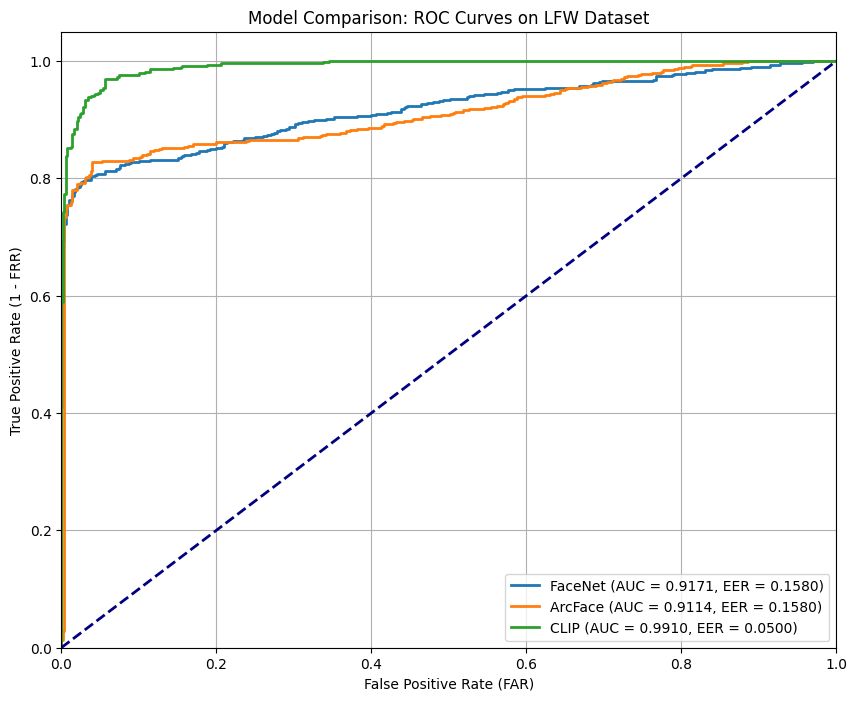

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
import os
from tqdm import tqdm
from PIL import Image

# --- Import our model libraries ---
from deepface import DeepFace
from sentence_transformers import SentenceTransformer

KAGGLE_PATH = '/kaggle/input/lfw-dataset'
LFW_DIR = f'{KAGGLE_PATH}/lfw-deepfunneled/lfw-deepfunneled'
GENUINE_FILE = f'{KAGGLE_PATH}/matchpairsDevTest.csv'
IMPOSTOR_FILE = f'{KAGGLE_PATH}/mismatchpairsDevTest.csv'
# -----------------------------------------------------------------

models = {}

def load_models():
    """Loads all models into memory to speed up processing."""
    print("Loading models (this may take a minute and download weights)...")

    warmup_img = f'{LFW_DIR}/Abel_Pacheco/Abel_Pacheco_0001.jpg'

    # 1. FaceNet (using deepface wrapper)
    try:
        DeepFace.represent(img_path=warmup_img,
                           model_name="Facenet",
                           enforce_detection=False)
        models['FaceNet'] = "loaded"
        print("FaceNet loaded.")
    except Exception as e:
        print(f"Could not pre-load FaceNet. Error: {e}")

    # 2. ArcFace (using deepface wrapper)
    try:
        DeepFace.represent(img_path=warmup_img,
                           model_name="ArcFace",
                           enforce_detection=False)
        models['ArcFace'] = "loaded"
        print("ArcFace loaded.")
    except Exception as e:
        print(f"Could not pre-load ArcFace. Error: {e}")

    # 3. CLIP
    models['CLIP'] = SentenceTransformer('clip-ViT-B-32')
    print("CLIP loaded.")
    print("All models loaded.")

def get_lfw_image_path(name, img_num):
    """Formats the LFW image path correctly."""
    num_str = str(img_num).zfill(4)
    img_name = f"{name}_{num_str}.jpg"
    return os.path.join(LFW_DIR, name, img_name)

def get_embedding(img_path, model_name):
    """
    A single function to get embeddings from our different models.
    """
    try:
        if model_name == 'FaceNet':
            embedding_obj = DeepFace.represent(img_path=img_path,
                                               model_name="Facenet",
                                               enforce_detection=False)
            return np.array(embedding_obj[0]["embedding"]).reshape(1, -1)

        elif model_name == 'ArcFace':
            embedding_obj = DeepFace.represent(img_path=img_path,
                                               model_name="ArcFace",
                                               enforce_detection=False)
            return np.array(embedding_obj[0]["embedding"]).reshape(1, -1)

        elif model_name == 'CLIP':
            img = Image.open(img_path)
            return models['CLIP'].encode(img, show_progress_bar=False).reshape(1, -1)

    except Exception as e:
        # print(f"Warning: Skipping {img_path} for {model_name}. Error: {e}")
        return None

def process_pairs_for_model(model_name):
    """
    Reads the DEV TEST files and gets all genuine/impostor scores.
    """
    genuine_scores = []
    impostor_scores = []

    print(f"\nProcessing genuine pairs for {model_name}...")
    with open(GENUINE_FILE, 'r') as f:
        lines = f.readlines()[1:] # Skip header
        for line in tqdm(lines, desc=f"Genuine ({model_name})"):
            try:
                parts = line.strip().split(',')
                path1 = get_lfw_image_path(parts[0], parts[1])
                path2 = get_lfw_image_path(parts[0], parts[2])

                emb1 = get_embedding(path1, model_name)
                emb2 = get_embedding(path2, model_name)

                if emb1 is not None and emb2 is not None:
                    score = cosine_similarity(emb1, emb2)[0][0]
                    genuine_scores.append(score)
            except Exception:
                continue # Skip bad lines

    print(f"\nProcessing impostor pairs for {model_name}...")
    with open(IMPOSTOR_FILE, 'r') as f:
        lines = f.readlines()[1:] # Skip header
        for line in tqdm(lines, desc=f"Impostor ({model_name})"):
            try:
                parts = line.strip().split(',')
                path1 = get_lfw_image_path(parts[0], parts[1])
                path2 = get_lfw_image_path(parts[2], parts[3])

                emb1 = get_embedding(path1, model_name)
                emb2 = get_embedding(path2, model_name)

                if emb1 is not None and emb2 is not None:
                    score = cosine_similarity(emb1, emb2)[0][0]
                    impostor_scores.append(score)
            except Exception:
                continue # Skip bad lines

    return genuine_scores, impostor_scores

def plot_comparison_roc(results):
    """Plots all ROC curves on one graph."""

    plt.figure(figsize=(10, 8))

    analysis_table = [
        "| Model | EER (Lower is better) | AUC (Higher is better) |",
        "| :--- | :--- | :--- |"
    ]

    for model_name, (genuine_scores, impostor_scores) in results.items():
        y_true = [1] * len(genuine_scores) + [0] * len(impostor_scores)
        y_scores = genuine_scores + impostor_scores

        fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
        fnr = 1 - tpr

        # Find EER & AUC
        eer_index = np.nanargmin(np.abs(fpr - fnr))
        eer = fpr[eer_index]
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2,
                 label=f'{model_name} (AUC = {roc_auc:.4f}, EER = {eer:.4f})')

        analysis_table.append(f"| **{model_name}** | **{eer:.4f}** | **{roc_auc:.4f}** |")

    # Finalize Plot
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FAR)')
    plt.ylabel('True Positive Rate (1 - FRR)')
    plt.title('Model Comparison: ROC Curves on LFW Dataset')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('model_comparison_roc.png')

    print("\n--- 📊 Task 2 Results 📊 ---")
    print("\n".join(analysis_table))
    print("\nComparison graph saved to model_comparison_roc.png")

# --- Run the full task ---
if __name__ == "__main__":
    if LFW_DIR.startswith('/home/your_user'):
        print("="*50)
        print("ERROR: Please update the KAGGLE_PATH at the top of the script.")
        print("="*50)
    else:
        load_models()

        models_to_test = ['FaceNet', 'ArcFace', 'CLIP']
        all_results = {}

        for model in models_to_test:
            g_scores, i_scores = process_pairs_for_model(model)
            if g_scores and i_scores:
                all_results[model] = (g_scores, i_scores)
            else:
                print(f"Failed to get scores for {model}. Skipping.")

        if all_results:
            plot_comparison_roc(all_results)
        else:
            print("No results were generated. Check your paths and installations.")